In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-09 11:59:00.409634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
os.chdir('/home/kubera/Documents/DLProjects/Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [14]:
#Process the data
train_path = '/home/kubera/Documents/DLProjects/Dataset/train'
valid_path = '/home/kubera/Documents/DLProjects/Dataset/valid'
test_path = '/home/kubera/Documents/DLProjects/Dataset/test'

In [15]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [16]:
assert train_batches.n == 1712
assert valid_batches.n == 300 
assert test_batches.n == 50 
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

In [17]:
#Modify Model 
mobile = tf.keras.applications.mobilenet.MobileNet()

2023-08-09 12:33:38.070606: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [33]:
x = mobile.layers[-5].output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = Dense(units=10, activation='softmax')(x)

In [34]:
model = Model(inputs=mobile.input, outputs=output)

In [35]:
for layer in model.layers[:-22]:
    layer.trainable = False

In [36]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [37]:
#Train the model 
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])                                                                                  

In [38]:
#Run for more epochs (~30) to see better results)
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


2023-08-09 12:49:49.883437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-09 12:55:48.768140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


172/172 - 419s - loss: 0.3754 - accuracy: 0.8744 - val_loss: 1.5573 - val_accuracy: 0.5300 - 419s/epoch - 2s/step
Epoch 2/10
172/172 - 437s - loss: 0.0329 - accuracy: 0.9895 - val_loss: 0.1371 - val_accuracy: 0.9733 - 437s/epoch - 3s/step
Epoch 3/10
172/172 - 505s - loss: 0.0761 - accuracy: 0.9772 - val_loss: 0.0988 - val_accuracy: 0.9800 - 505s/epoch - 3s/step
Epoch 4/10
172/172 - 565s - loss: 0.0353 - accuracy: 0.9877 - val_loss: 0.2552 - val_accuracy: 0.9400 - 565s/epoch - 3s/step
Epoch 5/10
172/172 - 689s - loss: 0.0093 - accuracy: 0.9977 - val_loss: 0.1292 - val_accuracy: 0.9667 - 689s/epoch - 4s/step
Epoch 6/10
172/172 - 687s - loss: 0.0741 - accuracy: 0.9796 - val_loss: 0.8680 - val_accuracy: 0.7367 - 687s/epoch - 4s/step
Epoch 7/10
172/172 - 630s - loss: 0.0812 - accuracy: 0.9772 - val_loss: 0.1347 - val_accuracy: 0.9800 - 630s/epoch - 4s/step
Epoch 8/10
172/172 - 526s - loss: 0.0456 - accuracy: 0.9871 - val_loss: 0.2076 - val_accuracy: 0.9467 - 526s/epoch - 3s/step
Epoch 9/10


In [39]:
#Predict sign language digits 
test_labels = test_batches.classes

In [40]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

2023-08-09 14:19:43.815414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [41]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
test_batches.class_indicies 

AttributeError: 'DirectoryIterator' object has no attribute 'class_indicies'

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 1 0 0]
 [0 0 0 0 4 0 0 1 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


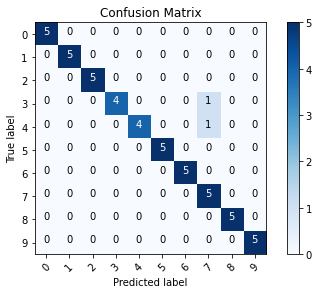

In [49]:
#Train the model for more epochs to see better results 
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')